# ICU-Predictor: Length of Stay (LOS) Prediction

This notebook predicts patient length of stay (LOS) in the ICU using deep learning models.
Cleaned: filler, duplicate, and non-working cells were removed.
Sections kept: data-download, preprocessing, sequence creation, and model training examples.

## Dataset
This notebook uses ICU patient data to predict length of stay (LOS).

Expected columns: `Patient_ID`, `Length_of_Stay` (target, numeric), and clinical features.If automatic download fails, set `dataset_path` to a local path containing `Dataset.csv`.

In [1]:
# Install lightweight helper (optional)
# You can comment this out if packages are already installed.
import kagglehub
print('kagglehub already installed')

kagglehub already installed


/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Try to download dataset via kagglehub; if it fails, set a fallback dataset_path.
dataset_path = None
try:
    import kagglehub
    print('Attempting kagglehub.dataset_download...')
    dataset_path = kagglehub.dataset_download('salikhussaini49/prediction-of-sepsis')
    print('Downloaded dataset to:', dataset_path)
except Exception as e:
    print('kagglehub download failed:', str(e))
    # Fallback: common kagglehub cache location used in this notebook before.
    dataset_path = '/root/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2'
    print('Using fallback dataset_path:', dataset_path)

# Verify existence (user should edit if different)
import os
if not os.path.exists(dataset_path):
    print('Warning: dataset_path does not exist:', dataset_path)
    print('If dataset is local, set dataset_path to the folder that contains Dataset.csv')

Attempting kagglehub.dataset_download...
Downloaded dataset to: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2
Downloaded dataset to: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2


In [3]:
# Consolidated: load data, preprocess, create sequences, and train a simple RNN for 1 epoch.
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

if dataset_path is None or not os.path.exists(dataset_path):
    raise FileNotFoundError(f'Dataset path not found: {dataset_path}. Please set dataset_path to the folder that contains Dataset.csv')

csv_file = os.path.join(dataset_path, 'Dataset.csv')
if not os.path.exists(csv_file):
    raise FileNotFoundError(f'Dataset.csv not found in {dataset_path}')

print('Loading Dataset.csv...')
df = pd.read_csv(csv_file)
print('Raw dataframe shape:', df.shape)

# Basic cleanup (drop auto index if present)
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Identify features and target
# For LOS prediction, target should be 'Length_of_Stay' (numeric, in days or hours)
los_col = None
for col in df.columns:
    if col in ['length_of_stay', 'ICULOS', 'stay_length', 'icu_los']:
        los_col = col
        break
if los_col is None:
    raise ValueError('Expected a length-of-stay column (e.g., Length_of_Stay, LOS) in Dataset.csv')
if 'Patient_ID' not in df.columns:
    raise ValueError('Expected column `Patient_ID` in Dataset.csv')
print(f'Using {los_col} as target variable for LOS prediction')

exclude_cols = [los_col, 'Patient_ID', 'Hour'] if 'Hour' in df.columns else [los_col, 'Patient_ID']
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in numerical_cols if c not in exclude_cols]
print(f'Found {len(feature_cols)} numerical feature columns.')

# Handle missing values per patient
for col in feature_cols:
    df[col] = df.groupby('Patient_ID')[col].ffill()
    df[col] = df.groupby('Patient_ID')[col].bfill()
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())

y = df[los_col]  # Length of Stay (regression target)
X = df[feature_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

# Patient-wise split
unique_patient_ids = df['Patient_ID'].unique()
pid_train, pid_temp = train_test_split(unique_patient_ids, test_size=0.3, random_state=42)
pid_val, pid_test = train_test_split(pid_temp, test_size=0.5, random_state=42)

df_train = df[df['Patient_ID'].isin(pid_train)]
df_val = df[df['Patient_ID'].isin(pid_val)]
df_test = df[df['Patient_ID'].isin(pid_test)]

# Sequence creation helper
def create_sequences(patient_df, X_scaled_data, y_data):
    X_seq = []
    y_seq = []
    for pid in patient_df['Patient_ID'].unique():
        idx = df[df['Patient_ID'] == pid].index
        X_seq.append(X_scaled_data.loc[idx].values)
        y_seq.append(y_data.loc[idx].values)
    return X_seq, y_seq

X_train_list, y_train_list = create_sequences(df_train, X_scaled_df, y)
X_val_list, y_val_list = create_sequences(df_val, X_scaled_df, y)
X_test_list, y_test_list = create_sequences(df_test, X_scaled_df, y)

max_seq = max(max(len(s) for s in X_train_list), max(len(s) for s in X_val_list), max(len(s) for s in X_test_list))
print('Max sequence length:', max_seq)

X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_train_seq = tf.keras.preprocessing.sequence.pad_sequences(y_train_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
X_val_seq = tf.keras.preprocessing.sequence.pad_sequences(X_val_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_val_seq = tf.keras.preprocessing.sequence.pad_sequences(y_val_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_test_seq = tf.keras.preprocessing.sequence.pad_sequences(y_test_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)

print('Shapes: ', X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape)

# Simple RNN model (sequence-to-sequence) - regression for LOS prediction
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='linear'))  # Linear activation for regression
])
rnn_model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])  # MSE for regression
rnn_model.summary()

print('Training RNN for 3 epochs (LOS regression)...')
history = rnn_model.fit(X_train_seq, y_train_seq, epochs=3, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('RNN training finished.')

2025-12-16 13:16:39.486163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 13:16:39.493646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765887399.501898  154598 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765887399.504942  154598 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765887399.511991  154598 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading Dataset.csv...
Raw dataframe shape: (1552210, 44)
Using ICULOS as target variable for LOS prediction
Found 40 numerical feature columns.
Raw dataframe shape: (1552210, 44)
Using ICULOS as target variable for LOS prediction
Found 40 numerical feature columns.
Max sequence length: 336
Max sequence length: 336
Shapes:  (28235, 336, 40) (28235, 336) (6050, 336, 40) (6050, 336)
Shapes:  (28235, 336, 40) (28235, 336) (6050, 336, 40) (6050, 336)


I0000 00:00:1765887438.356017  154598 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4284 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5060 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0
/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 336, 128)       │        21,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 336, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,761 (85.00 KB)

 Trainable params: 21,761 (85.00 KB)

 Non-trainable params: 0 (0.00 B)

Training RNN for 3 epochs (LOS regression)...
Epoch 1/3
Epoch 1/3


I0000 00:00:1765887443.912025  155124 service.cc:152] XLA service 0x5644eaee0b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765887443.912045  155124 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 5060 Ti, Compute Capability 12.0
2025-12-16 13:17:24.076872: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765887444.502486  155124 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1765887444.502486  155124 cuda_dnn.cc:529] Loaded cuDNN version 91002


  4/442 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 148.2904 - mae: 3.0141   

I0000 00:00:1765887455.993226  155124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 167.6906 - mae: 3.6422

2025-12-16 13:18:01.166809: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_1', 924 bytes spill stores, 1024 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_8', 512 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_7', 512 bytes spill stores, 508 bytes spill loads



442/442 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - loss: 161.8444 - mae: 3.9961 - val_loss: 143.4954 - val_mae: 4.2249
Epoch 2/3
Epoch 2/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 167.5653 - mae: 4.3533 - val_loss: 165.5155 - val_mae: 3.2518
Epoch 3/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 167.5653 - mae: 4.3533 - val_loss: 165.5155 - val_mae: 3.2518
Epoch 3/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 170.8227 - mae: 4.7883 - val_loss: 166.1659 - val_mae: 4.9589
RNN training finished.
442/442 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 170.8227 - mae: 4.7883 - val_loss: 166.1659 - val_mae: 4.9589
RNN training finished.


In [4]:
# CNN model example (sequence-to-sequence) - keeps sequence length by using padding='same'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu', padding='same'),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='linear'))  # Linear activation for regression
])
cnn_model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])  # MSE for regression
cnn_model.summary()

print('Training CNN for 3 epochs (LOS regression)...')
history_cnn = cnn_model.fit(X_train_seq, y_train_seq, epochs=3, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('CNN training finished.')

/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 336, 64)        │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 336, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 336, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,577 (127.25 KB)

 Trainable params: 32,577 (127.25 KB)

 Non-trainable params: 0 (0.00 B)

Training CNN for 3 epochs (LOS regression)...
Epoch 1/3
Epoch 1/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 98.6072 - mae: 2.3943

2025-12-16 13:19:04.019339: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion_1', 444 bytes spill stores, 444 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_5', 512 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_4', 512 bytes spill stores, 508 bytes spill loads



442/442 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - loss: 92.7417 - mae: 2.1793 - val_loss: 87.6771 - val_mae: 1.9197
Epoch 2/3
Epoch 2/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 84.4362 - mae: 1.9719 - val_loss: 85.2397 - val_mae: 1.9454
Epoch 3/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 84.4362 - mae: 1.9719 - val_loss: 85.2397 - val_mae: 1.9454
Epoch 3/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 81.8311 - mae: 1.9721 - val_loss: 84.5059 - val_mae: 1.9485
CNN training finished.
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 81.8311 - mae: 1.9721 - val_loss: 84.5059 - val_mae: 1.9485
CNN training finished.


In [5]:
# LGSTM (layered LSTM) model: stacked LSTM layers for sequence-to-sequence prediction
from tensorflow.keras.layers import LSTM, Bidirectional

print('Defining LGSTM (stacked LSTM) model...')
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

lgstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='linear'))  # Linear activation for regression
])

lgstm_model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])  # MSE for regression
lgstm_model.summary()

print('Training LGSTM for 5 epochs (LOS regression)...')
history_lgstm = lgstm_model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('LGSTM training finished.')

Defining LGSTM (stacked LSTM) model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 336, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 336, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 336, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,001 (531.25 KB)

 Trainable params: 136,001 (531.25 KB)

 Non-trainable params: 0 (0.00 B)

Training LGSTM for 5 epochs (LOS regression)...
Epoch 1/5
Epoch 1/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 103.0226 - mae: 1.8963 - val_loss: 71.5250 - val_mae: 1.0645
Epoch 2/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 103.0226 - mae: 1.8963 - val_loss: 71.5250 - val_mae: 1.0645
Epoch 2/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 65.3987 - mae: 0.9674 - val_loss: 52.2251 - val_mae: 0.6824
Epoch 3/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 65.3987 - mae: 0.9674 - val_loss: 52.2251 - val_mae: 0.6824
Epoch 3/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 50.9360 - mae: 0.7729 - val_loss: 40.8743 - val_mae: 0.5169
Epoch 4/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 50.9360 - mae: 0.7729 - val_loss: 40.8743 - val_mae: 0.5169
Epoch 4/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 41.4857 - mae: 0.6858 - val_loss: 32.8478 - val_mae: 0.4610
Epoch 5/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 41.4857 - mae: 0.6858 - val_loss


=== Model Evaluations on Test Set ===
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
Evaluation for RNN:
  MSE: 153.4072, RMSE: 12.3858, MAE: 4.9300
  R²: 0.0239
Evaluation for RNN:
  MSE: 153.4072, RMSE: 12.3858, MAE: 4.9300
  R²: 0.0239


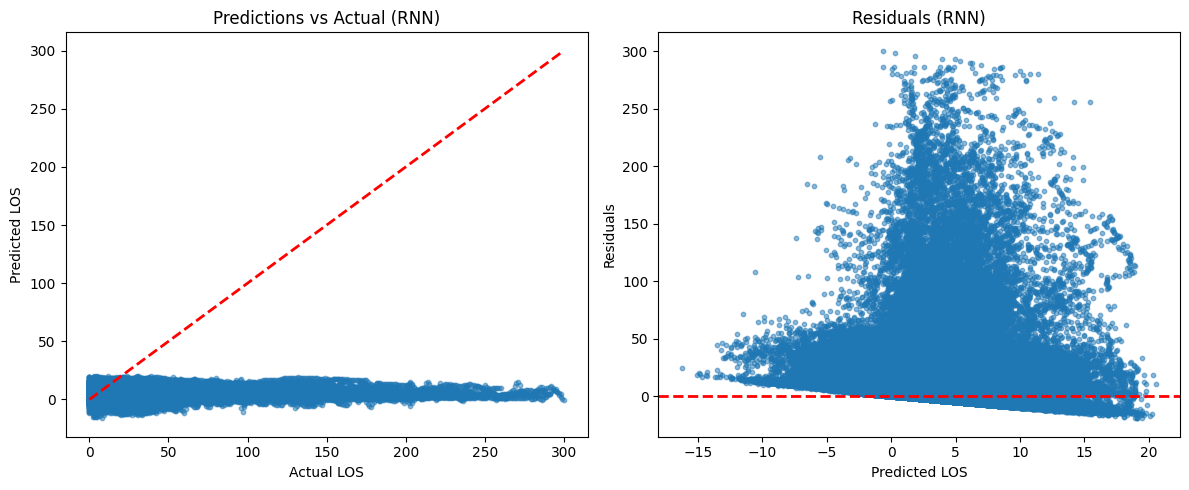

190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Evaluation for CNN:
  MSE: 74.5777, RMSE: 8.6358, MAE: 1.8974
  R²: 0.5255
Evaluation for CNN:
  MSE: 74.5777, RMSE: 8.6358, MAE: 1.8974
  R²: 0.5255


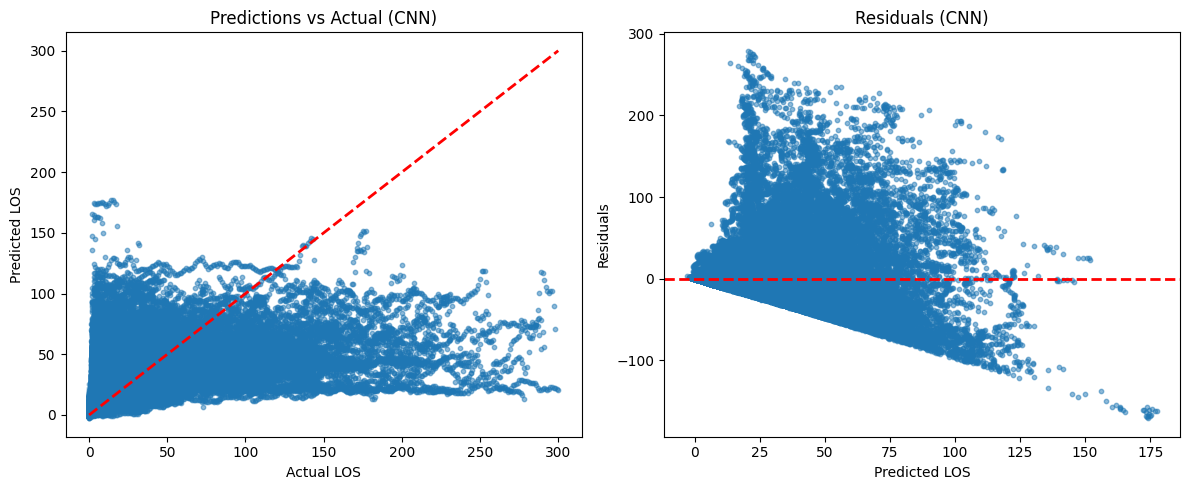

190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Evaluation for LGSTM:
  MSE: 20.8477, RMSE: 4.5659, MAE: 0.3640
  R²: 0.8674
Evaluation for LGSTM:
  MSE: 20.8477, RMSE: 4.5659, MAE: 0.3640
  R²: 0.8674


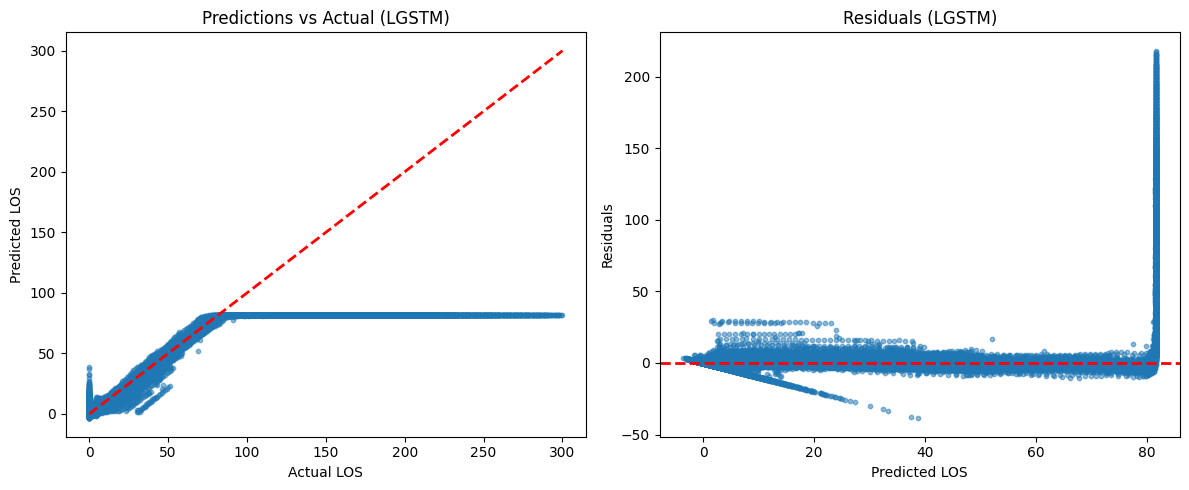


=== Summary ===
RNN   - RMSE: 12.3858, MAE: 4.9300, R²: 0.0239
CNN   - RMSE: 8.6358, MAE: 1.8974, R²: 0.5255
LGSTM - RMSE: 4.5659, MAE: 0.3640, R²: 0.8674
Done evaluations.


In [6]:
# Evaluation: compute regression metrics (MSE, MAE, RMSE, R²)
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_los_model(model, X_seq, y_seq, name='model'):
    # Predict LOS values (shape: samples, seq_len, 1)
    preds = model.predict(X_seq)
    preds_flat = preds.reshape(-1)
    y_flat = y_seq.reshape(-1)

    mse = mean_squared_error(y_flat, preds_flat)
    mae = mean_absolute_error(y_flat, preds_flat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_flat, preds_flat)

    print(f"Evaluation for {name}:")
    print(f"  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")

    # Prediction vs actual plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_flat, preds_flat, alpha=0.5, s=10)
    plt.plot([y_flat.min(), y_flat.max()], [y_flat.min(), y_flat.max()], 'r--', lw=2)
    plt.xlabel('Actual LOS')
    plt.ylabel('Predicted LOS')
    plt.title(f'Predictions vs Actual ({name})')

    # Residuals plot
    residuals = y_flat - preds_flat
    plt.subplot(1,2,2)
    plt.scatter(preds_flat, residuals, alpha=0.5, s=10)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted LOS')
    plt.ylabel('Residuals')
    plt.title(f'Residuals ({name})')
    plt.tight_layout()
    plt.show()

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate models
print('\n=== Model Evaluations on Test Set ===')
metrics_rnn = evaluate_los_model(rnn_model, X_test_seq, y_test_seq, name='RNN')
metrics_cnn = evaluate_los_model(cnn_model, X_test_seq, y_test_seq, name='CNN')
metrics_lgstm = evaluate_los_model(lgstm_model, X_test_seq, y_test_seq, name='LGSTM')

print('\n=== Summary ===')
print(f'RNN   - RMSE: {metrics_rnn["rmse"]:.4f}, MAE: {metrics_rnn["mae"]:.4f}, R²: {metrics_rnn["r2"]:.4f}')
print(f'CNN   - RMSE: {metrics_cnn["rmse"]:.4f}, MAE: {metrics_cnn["mae"]:.4f}, R²: {metrics_cnn["r2"]:.4f}')
print(f'LGSTM - RMSE: {metrics_lgstm["rmse"]:.4f}, MAE: {metrics_lgstm["mae"]:.4f}, R²: {metrics_lgstm["r2"]:.4f}')
print('Done evaluations.')